# Adam Trentowski - 162602 - Machine Learning
## lab_09
## Library Imports

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(np.sum([ord(i) for i in 'StackerPy Testing']))

## * Initialize a class, defining instance variables for later use
## * Function to Model validation – checking the presence of prediction methods
## * Static prediction method (probabilistic or classical)
## * Function to Matching the Baseline and Blending Models
## * Function to Prediction based on trained model stack

In [21]:
class StackerModel:
    def __init__(self):
        self.X = None
        self.y = None
        self.blend = None
        self.splits = None
        self.model_feature_indices = None
        self.model_methods = []
        self.metafeatures_df = None
        self.X_with_metafeatures = None
        self.raw_models = None
        self.fit_models = dict()
        self.fit_blended_models = dict()
        self.raw_stacker = None
        self.stacker = None

    def validate_models(self, models):
        for model in models:
            model_name = model.__str__().split('(')[0]

            assert any(['predict' in dir(model), 'predict_proba' in dir(model)]), \
                f"""{model_name} does not have a predict or predict_proba method"""

            if 'predict_proba' not in dir(model) and 'predict' in dir(model):
                print(f'Note: There is no predict_proba method in {model_name}, therefore predict method will be used')
                self.model_methods.append('predict')

            if 'predict_proba' in dir(model):
                self.model_methods.append('predict_proba')

    @staticmethod
    def model_predictor(model, X, method):
        predictions = None
        if method == 'predict_proba':
            predictions = model.predict_proba(X)[:, 1]
        if method == 'predict':
            predictions = model.predict(X)

        return predictions

    def fit(self, X, y, models, stacker, blend=False, splits=5, model_feature_indices=None):
        self.__init__()
        self.raw_models = models
        self.raw_stacker = stacker
        self.blend = blend
        self.splits = splits
        self.model_feature_indices = model_feature_indices
        self.validate_models(models)

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X).reset_index(drop=True)
        if not isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y).reset_index(drop=True)

        if self.model_feature_indices is None:
            self.model_feature_indices = [[i for i in range(X.shape[1])] for _ in models]

        self.model_names_list = [model.__str__().split('(')[0] for model in self.raw_models]
        self.metafeatures_df = pd.DataFrame(index=range(X.shape[0]), columns=self.model_names_list)

        for model, features, method in zip(self.raw_models, self.model_feature_indices, self.model_methods):
            model_name = model.__str__().split('(')[0]
            X_model_features = X.iloc[:, features]

            metafeatures = None

            if self.blend is False:
                model.fit(X_model_features, np.ravel(y))
                metafeatures = self.model_predictor(model, X_model_features, method)
                self.fit_models[model_name] = model

            if self.blend is True:
                self.fit_blended_models[model_name] = []
                kf = KFold(n_splits=self.splits)
                metafeatures = pd.Series(np.zeros(X.shape[0]))

                for idx, (train_idx, meta_idx) in enumerate(kf.split(X_model_features)):
                    model.fit(X_model_features.iloc[train_idx, :], np.ravel(y.iloc[train_idx, :]))
                    meta = self.model_predictor(model, X_model_features.iloc[meta_idx, :], method)
                    metafeatures.iloc[meta_idx] = meta
                    self.fit_blended_models[model_name].append(model)

                self.metafeatures_df[model_name] = metafeatures

        self.X_with_metafeatures = pd.concat([X.reset_index(drop=True), self.metafeatures_df.reset_index(drop=True)], axis=1)
        self.stacker = stacker.fit(self.X_with_metafeatures, np.ravel(y))

    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X).reset_index()

        metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)

        if self.blend is False:
            for (model_name, model), features, method in zip(self.fit_models.items(), self.model_feature_indices, self.model_methods):
                X_model_features = X.iloc[:, features]
                metafeatures = self.model_predictor(model, X_model_features, method)
                metafeatures_df[model_name] = metafeatures
        if self.blend is True:
            for (model_name, model_list), features, method in zip(self.fit_blended_models.items(), self.model_feature_indices, self.model_methods):
                X_model_features = X.iloc[:, features]
                model_df = pd.DataFrame()
                for model_idx, model in enumerate(model_list):
                    meta = self.model_predictor(model, X_model_features, method)
                    model_df[model_idx] = meta
                metafeatures = np.mean(model_df, axis=1)
                metafeatures_df[model_name] = metafeatures

        X_with_metafeatures = pd.concat([X.reset_index(drop=True), metafeatures_df.reset_index(drop=True)], axis=1)
        return self.stacker.predict(X_with_metafeatures)

## Loading a dataset and separating features from the label

In [22]:
df = pd.read_csv("VLagun_Total_Years4.csv")
X = df.iloc[:, 0:57].values
y = df.iloc[:, 57].values

## Data division into training and test sets (80/20)

In [23]:
X = df.iloc[:, 0:57]
Y = df.iloc[:, 57]
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (96, 57)
Shape of X_test: (24, 57)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=np.sum([ord(i) for i in 'StackerPy'])
)

## Preparing an empty results table

In [25]:
results = pd.DataFrame()

## Random Forest Training and Evaluation

In [26]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, np.ravel(y_train))
random_forest_predictions = random_forest.predict(X_test)

print('Original Random Forest Classifier Results')
print(classification_report(y_test, random_forest_predictions))

random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_recall = recall_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions)
random_forest_f1 = f1_score(y_test, random_forest_predictions)

print('Accuracy Score: ', random_forest_accuracy)
print('Recall Score: ', random_forest_recall)
print('Precision Score: ', random_forest_precision)
print('F1 Score: ', random_forest_f1)

Original Random Forest Classifier Results
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.87      0.93        15

    accuracy                           0.92        24
   macro avg       0.91      0.93      0.91        24
weighted avg       0.93      0.92      0.92        24

Accuracy Score:  0.9166666666666666
Recall Score:  0.8666666666666667
Precision Score:  1.0
F1 Score:  0.9285714285714286


## Training and Evaluating Logistic Regression

In [27]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10_000)
logistic.fit(X_train, np.ravel(y_train))
logistic_predictions = logistic.predict(X_test)

print('Original Logistic Regression Classifier Results')
print(classification_report(y_test, logistic_predictions))

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)

print('Accuracy Score: ', logistic_accuracy)
print('Recall Score: ', logistic_recall)
print('Precision Score: ', logistic_precision)
print('F1 Score: ', logistic_f1)

Original Logistic Regression Classifier Results
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.87      0.93        15

    accuracy                           0.92        24
   macro avg       0.91      0.93      0.91        24
weighted avg       0.93      0.92      0.92        24

Accuracy Score:  0.9166666666666666
Recall Score:  0.8666666666666667
Precision Score:  1.0
F1 Score:  0.9285714285714286


## Decision Tree Training and Evaluation

In [28]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, np.ravel(y_train))
dtree_predictions = dtree.predict(X_test)

print('Original Decision Tree Classifier Results')
print(classification_report(y_test, dtree_predictions))

dtree_accuracy = accuracy_score(y_test, dtree_predictions)
dtree_recall = recall_score(y_test, dtree_predictions)
dtree_precision = precision_score(y_test, dtree_predictions)
dtree_f1 = f1_score(y_test, dtree_predictions)

print('Accuracy Score: ', dtree_accuracy)
print('Recall Score: ', dtree_recall)
print('Precision Score: ', dtree_precision)
print('F1 Score: ', dtree_f1)

Original Decision Tree Classifier Results
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.93      0.87      0.90        15

    accuracy                           0.88        24
   macro avg       0.86      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24

Accuracy Score:  0.875
Recall Score:  0.8666666666666667
Precision Score:  0.9285714285714286
F1 Score:  0.896551724137931


## Ridge Classifier Training and Evaluation

In [29]:
ridge = RidgeClassifier()
ridge.fit(X_train, np.ravel(y_train))
ridge_predictions = ridge.predict(X_test)

print('Original Ridge Classifier Results')
print(classification_report(y_test, ridge_predictions))

ridge_accuracy = accuracy_score(y_test, ridge_predictions)
ridge_recall = recall_score(y_test, ridge_predictions)
ridge_precision = precision_score(y_test, ridge_predictions)
ridge_f1 = f1_score(y_test, ridge_predictions)

print('Accuracy Score: ', ridge_accuracy)
print('Recall Score: ', ridge_recall)
print('Precision Score: ', ridge_precision)
print('F1 Score: ', ridge_f1)

Original Ridge Classifier Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        15

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Accuracy Score:  1.0
Recall Score:  1.0
Precision Score:  1.0
F1 Score:  1.0


## Training and Evaluating the Stacker Model with Blending

In [31]:
lr2 = LogisticRegression(solver='lbfgs', max_iter=10_000)
dt2 = DecisionTreeClassifier()
rf2 = RandomForestClassifier(n_estimators=25)
rc2 = RidgeClassifier()
models = [lr2, dt2, rf2]

stacker = StackerModel()
stacker.fit(X=X_train, y=y_train, models=models, stacker=rc2, blend=True, splits=5)
stacker_predictions = stacker.predict(X_test)

print('Stacker Model Results with blending')
print(classification_report(y_test, stacker_predictions))

stacker_accuracy = accuracy_score(y_test, stacker_predictions)
stacker_recall = recall_score(y_test, stacker_predictions)
stacker_precision = precision_score(y_test, stacker_predictions)
stacker_f1 = f1_score(y_test, stacker_predictions)

print('Accuracy Score: ', stacker_accuracy)
print('Recall Score: ', stacker_recall)
print('Precision Score: ', stacker_precision)
print('F1 Score: ', stacker_f1)

Stacker Model Results with blending
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

Accuracy Score:  0.9583333333333334
Recall Score:  0.9333333333333333
Precision Score:  1.0
F1 Score:  0.9655172413793104


## Filling the metrics table with the results of all models

In [32]:
results['model'] = ['Random\nForest',
                    'Logistic\nRegressioon',
                    'Decision\nTree',
                    'Ridge\nClassifier',
                    'Stacker\nModel']

results['accuracy'] = [random_forest_accuracy,
                       logistic_accuracy,
                       dtree_accuracy,
                       ridge_accuracy,
                       stacker_accuracy]

results['recall'] = [random_forest_recall,
                     logistic_recall,
                     dtree_recall,
                     ridge_recall,
                     stacker_recall]

results['precision'] = [random_forest_precision,
                        logistic_precision,
                        dtree_precision,
                        ridge_precision,
                        stacker_precision]

results['f1'] = [random_forest_f1,
                 logistic_f1,
                 dtree_f1,
                 ridge_f1,
                 stacker_f1]

## Results visualization: accuracy, precision, recall, F1 comparison

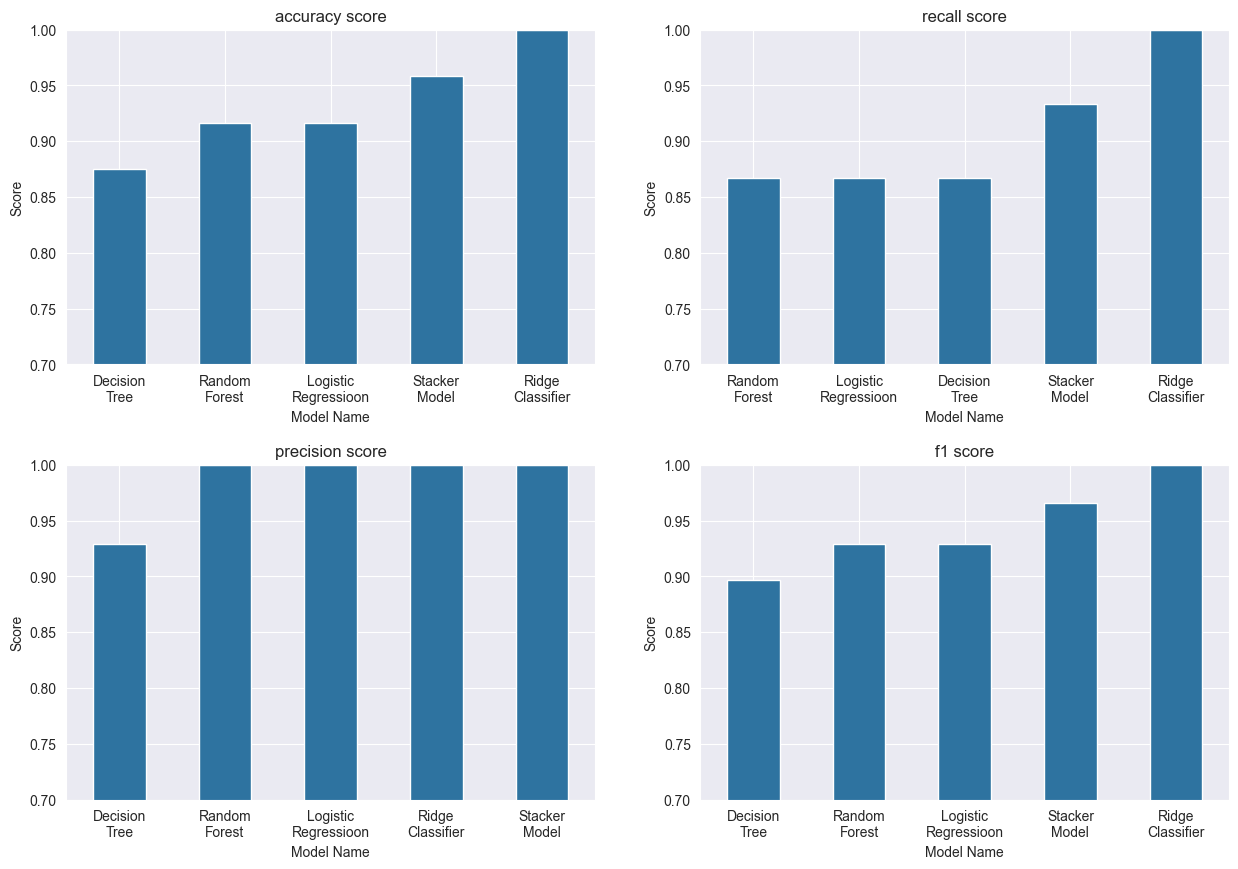

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
((ax1, ax2), (ax3, ax4)) = axes

for ax, score in zip([ax1, ax2, ax3, ax4], results.columns[1:]):
    ax.set_title(f'{score} score')
    ax.set_ylabel('Score')
    results.set_index('model')[score].sort_values().plot(kind='bar', ax=ax, fontsize=10, color='#2E73A0')
    ax.set_xlabel('Model Name')
    ax.set_ylim([0.7, 1])
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

plt.show()